# Food Vision

**Original Paper** -> https://arxiv.org/pdf/1606.05675.pdf

> Trying to beat the `77.4%` in `Top-1 accuracy` column with this notebook.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a5e19314-97dc-0d73-7626-7111e746d2c8)


## Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

import os
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

## Importing helper functions

In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-07 12:01:38--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14510 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.17K  --.-KB/s    in 0.001s  

2022-08-07 12:01:38 (11.9 MB/s) - ‘helper_functions.py’ saved [14510/14510]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image

## Tensorflow Datasets

**Original Link** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

**Food101 Dataset** -> https://www.tensorflow.org/datasets/catalog/food101

## Load the Data

In [5]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete8UG3LJ/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete8UG3LJ/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## Exploring the Food101 Dataset

In [8]:
class_names= ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
len(train_data)

75750

In [10]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_one_sample= train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
        


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [14]:
image.shape

TensorShape([512, 512, 3])

In [15]:
image/255,

(<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
 array([[[0.65882355, 0.5803922 , 0.48235294],
         [0.7529412 , 0.6745098 , 0.5764706 ],
         [0.78431374, 0.7058824 , 0.60784316],
         ...,
         [0.7019608 , 0.64705884, 0.54509807],
         [0.7372549 , 0.6745098 , 0.5764706 ],
         [0.6039216 , 0.5411765 , 0.44313726]],
 
        [[0.72156864, 0.6431373 , 0.54509807],
         [0.81960785, 0.7411765 , 0.6431373 ],
         [0.83137256, 0.7529412 , 0.654902  ],
         ...,
         [0.8117647 , 0.75686276, 0.654902  ],
         [0.85490197, 0.7921569 , 0.69411767],
         [0.72156864, 0.65882355, 0.56078434]],
 
        [[0.7294118 , 0.6509804 , 0.54509807],
         [0.8392157 , 0.7607843 , 0.654902  ],
         [0.827451  , 0.7607843 , 0.65882355],
         ...,
         [0.8117647 , 0.75686276, 0.654902  ],
         [0.8509804 , 0.79607844, 0.69411767],
         [0.7058824 , 0.6509804 , 0.54901963]],
 
        ...,
 
        [[0.80784315, 0.7764706 

In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

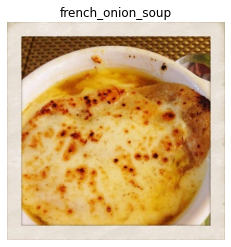

In [17]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

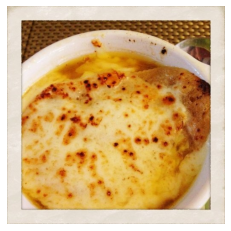

In [18]:
plt.imshow(image)
plt.axis(False);

Image shape: (512, 289, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 45
    Class name (str form): frozen_yogurt
Image shape: (512, 288, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 93
    Class name (str form): steak
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 16
    Class name (str form): cheesecake
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 18
    Class name (str form): chicken_curry
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 72
    Class name (str form): pancakes
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (384, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 

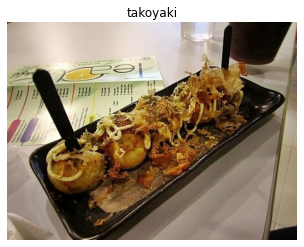

In [19]:
train_one_sample=[]
for i in range(10):
  train_one_sample.append(train_data.take(1))
  for image, label in train_one_sample[i]:
    plt.imshow(image/255)
    plt.title(class_names[label.numpy()])
    plt.axis(False);
    print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
  

In [20]:
train_one_sample= train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Preprocessing function to preprocess our data

> Neural Network perform best when data is in a certain way(e.g. `batched, normalized, etc`)

> Before we pass, the data to the model for training, we need to do a few thing to the data for it to be eligiable to be passed to the model for training

### what are the problems with the data we have currently:-

* Images are in `uint8` datatype

* Images are of varying sizes

* Images are not scaled(between 0-1)

### What type of data, models like:

* Data needs to be in `float32` dtype(or for `mixed precision` in `float16 and float32`)

* For Batches, Tensorflow likes the images in a `constant/consistent/same size`.

* Normalized/scaled data(values between 0-1) speeds up the traning process and helps the model learn the patterns of the dataset faster

#### Working of the preprocessing function

* Reshaping all of the images to the same size
* Convert all of the dtypes of our image tensors from `uint8` to `float32` which models like.

In [21]:
def preprocess_image(image, label, img_shape=224, scaling=False):
  """
    Converts any image datatype to 'float32', and reshapes the images to [img_shape, img_shape, color_channels]
    Args:
      image: The image to the preprocesses
      label: string, The label of the image
      img_shape: int, Default is '224'. The shape to which the image is preprocessed into.
    Returns:
      (newImage, label) respectively as a tupel

  """
  image= tf.image.resize(image, [img_shape, img_shape]) # Resizing the image into a same size.
  if scaling:
    image= image/255. # Scaling/Normalizing values of the image. EfficientNetBx models have build-in rescaling layers
  newdtypeImage= tf.cast(image, tf.float32) # Changing the dtype of the image into float32
  return newdtypeImage, label

### Trying the preprocessed function

In [22]:
preprocessed_img, preprocessed_label= preprocess_image(image, label)

In [23]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 56.23469  ,  32.591835 ,  27.877552 ],
        [ 98.16328  ,  75.16328  ,  68.50001  ],
        [121.62245  , 101.62245  ,  91.63265  ],
        ...,
        [191.72456  , 191.36736  , 170.93883  ],
        [202.18863  , 196.9743   , 176.90286  ],
        [185.918    , 174.10167  , 153.6169   ]],

       [[ 93.47959  ,  73.55102  ,  64.19388  ],
        [144.57143  , 124.64286  , 113.561226 ],
        [169.66327  , 150.20409  , 138.79082  ],
        ...,
        [196.22955  , 195.22955  , 176.80103  ],
        [202.02025  , 194.9335   , 175.87225  ],
        [182.24942  , 168.44324  , 148.72888  ]],

       [[166.51021  , 149.08163  , 133.51021  ],
        [169.28572  , 151.85715  , 136.28572  ],
        [172.10204  , 155.67348  , 140.10204  ],
        ...,
        [193.92346  , 191.68872  , 174.21426  ],
        [200.37233  , 191.62741  , 174.35698  ],
        [180.43791  , 164.87663  , 145.44292  ]],

       ...,

     

In [24]:
preprocessed_img_1, preprocessed_label_1= preprocess_image(image, label, scaling=False)

In [25]:
preprocessed_img_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 56.23469  ,  32.591835 ,  27.877552 ],
        [ 98.16328  ,  75.16328  ,  68.50001  ],
        [121.62245  , 101.62245  ,  91.63265  ],
        ...,
        [191.72456  , 191.36736  , 170.93883  ],
        [202.18863  , 196.9743   , 176.90286  ],
        [185.918    , 174.10167  , 153.6169   ]],

       [[ 93.47959  ,  73.55102  ,  64.19388  ],
        [144.57143  , 124.64286  , 113.561226 ],
        [169.66327  , 150.20409  , 138.79082  ],
        ...,
        [196.22955  , 195.22955  , 176.80103  ],
        [202.02025  , 194.9335   , 175.87225  ],
        [182.24942  , 168.44324  , 148.72888  ]],

       [[166.51021  , 149.08163  , 133.51021  ],
        [169.28572  , 151.85715  , 136.28572  ],
        [172.10204  , 155.67348  , 140.10204  ],
        ...,
        [193.92346  , 191.68872  , 174.21426  ],
        [200.37233  , 191.62741  , 174.35698  ],
        [180.43791  , 164.87663  , 145.44292  ]],

       ...,

     

original Image
Image shape: (384, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 97
    Class name (str form): takoyaki


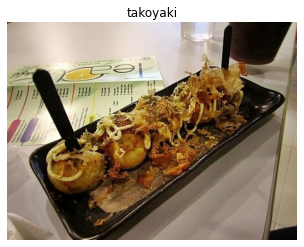

In [26]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 97
    Class name (str form): takoyaki


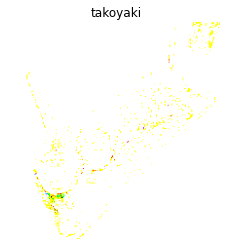

In [27]:
print("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img.shape} Image dtype: {preprocessed_img.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 97
    Class name (str form): takoyaki


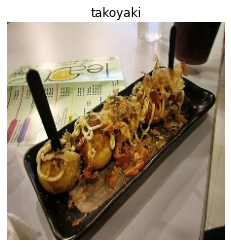

In [28]:
print("Preprocessed Image")
plt.imshow(preprocessed_img_1/255)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img_1.shape} Image dtype: {preprocessed_img_1.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label_1}
    Class name (str form): {class_names[preprocessed_label_1.numpy()]}""")
plt.axis(False);

## Creating batches of the dataset and preparing the datasets

**Resources** -> https://www.tensorflow.org/guide/data_performance

In [29]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [30]:
# Mapped the preprocessing function to training data
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# Mapped the preprocessing function to test data
test_data= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


## Explanation

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batc

In [31]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create Modelling callbacks

In [33]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback

In [34]:
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")
checkpoint_callback=model_check_point_callback("checkpoints", save_weights_only=True, save_best_only=True, monitor="val_accuracy")
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220807-121025


## Mixed Precision Training

> Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

**Guide** -> https://www.tensorflow.org/guide/mixed_precision

## Adding Augmented Layer

In [35]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turnining on Mixed Precision Training


In [36]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [37]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [38]:
len(class_names)

101

In [39]:
CLASS_COUNT=len(class_names)

## Build Feature extraction model with `Dropout` and `Regularization` layers

In [40]:
# input_shape=(512, 512,3)
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= layers.Input(shape= input_shape, name="input_layer")
# x= preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs)
x= base_model(x, training=False)
x= layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))(x)
x=layers.Dense(len(class_names))(x)
outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model= tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

16719872/16705208 [==============================] - 0s 0us/step


In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381

## Checking the layers of the model

* `layer.name` -> Human readable name of the layer
* `layer.trainable` -> Boolean, layer is trainable or not, if the layers are frozen or unfrozen
* `layer.dtype` -> The dtype format in which the layer stores the variables in

* `layer.dtype_policy` -> The dype_policy in which the layer computes the variables in

In [42]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Checking the layers of the base_model(EfficientNetB0)

In [43]:
for layer in base_model.layers[:20]: 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [44]:
for layer in model.layers[1].layers[:20]: 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

random_flip True float32 <Policy "float32">
random_rotation True float32 <Policy "float32">
random_zoom True float32 <Policy "float32">
random_height True float32 <Policy "float32">
random_width True float32 <Policy "float32">


## Training the feature_extraction layer

In [45]:
history_feature_extraction= model.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

Epoch 1/15
2368/2368 [==============================] - ETA: 0s - loss: 2.6259 - accuracy: 0.3818
Epoch 1: val_accuracy improved from -inf to 0.58951, saving model to checkpoints
2368/2368 [==============================] - 241s 93ms/step - loss: 2.6259 - accuracy: 0.3818 - val_loss: 1.6253 - val_accuracy: 0.5895
Epoch 2/15
2368/2368 [==============================] - ETA: 0s - loss: 2.3093 - accuracy: 0.4537
Epoch 2: val_accuracy improved from 0.58951 to 0.61758, saving model to checkpoints
2368/2368 [==============================] - 188s 79ms/step - loss: 2.3093 - accuracy: 0.4537 - val_loss: 1.5608 - val_accuracy: 0.6176
Epoch 3/15
2368/2368 [==============================] - ETA: 0s - loss: 2.2714 - accuracy: 0.4642
Epoch 3: val_accuracy improved from 0.61758 to 0.62076, saving model to checkpoints
2368/2368 [==============================] - 209s 88ms/step - loss: 2.2714 - accuracy: 0.4642 - val_loss: 1.5581 - val_accuracy: 0.6208
Epoch 4/15
2368/2368 [===========================

In [46]:
model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.5608 - accuracy: 0.6235


[1.5607759952545166, 0.6235247254371643]

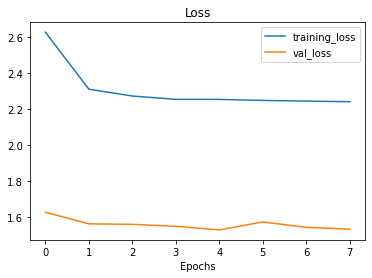

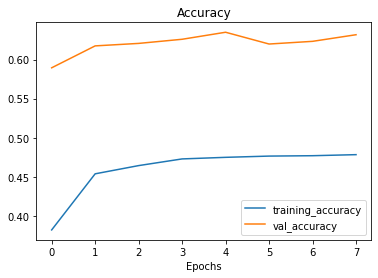

In [47]:
plot_loss_curves(history_feature_extraction)

In [48]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 54s 68ms/step - loss: 1.5608 - accuracy: 0.6235


## Trying the model with increased batch size

> As we are using `Mixed precision` training and `float16` tensors use half the memory.

`BATCH_SIZE = 128`

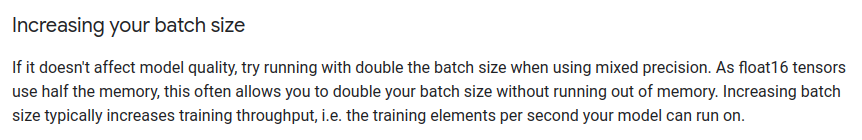

In [ ]:
# # Mapped the preprocessing function to training data
# train_data128= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# # Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
# train_data128= train_data128.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# # Mapped the preprocessing function to test data
# test_data128= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)


In [ ]:
# # input_shape=(512, 512,3)
# input_shape=(224,224,3)
# base_model= tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= layers.Input(shape= input_shape, name="input_layer")
# # x= preprocessing.Rescaling(1./255)(x)
# x= base_model(inputs, training=False)
# x= layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x=layers.Dense(len(class_names))(x)
# outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model_128= tf.keras.Model(inputs, outputs)

# model_128.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

# history_feature_extraction_128= model_128.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

## Running the model without `Dropout` and `Regularization` layers added

In [ ]:
# # Mapped the preprocessing function to training data
# train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# # Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
# train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# # Mapped the preprocessing function to test data
# test_data= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# input_shape=(512, 512,3)
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= layers.Input(shape= input_shape, name="input_layer")
# x= preprocessing.Rescaling(1./255)(x)
x= base_model(inputs, training=False)
x= layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1= tf.keras.Model(inputs, outputs)

model_1.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_feature_extraction_1= model_1.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

Epoch 1/15
2368/2368 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.5571
Epoch 1: val_accuracy improved from 0.63506 to 0.67664, saving model to checkpoints
2368/2368 [==============================] - 180s 73ms/step - loss: 1.8210 - accuracy: 0.5571 - val_loss: 1.2272 - val_accuracy: 0.6766
Epoch 2/15
2367/2368 [============================>.] - ETA: 0s - loss: 1.2934 - accuracy: 0.6669
Epoch 2: val_accuracy improved from 0.67664 to 0.70710, saving model to checkpoints
2368/2368 [==============================] - 165s 69ms/step - loss: 1.2934 - accuracy: 0.6669 - val_loss: 1.1206 - val_accuracy: 0.7071
Epoch 3/15
2367/2368 [============================>.] - ETA: 0s - loss: 1.1428 - accuracy: 0.7030
Epoch 3: val_accuracy improved from 0.70710 to 0.71001, saving model to checkpoints
2368/2368 [==============================] - 201s 84ms/step - loss: 1.1428 - accuracy: 0.7030 - val_loss: 1.0769 - val_accuracy: 0.7100
Epoch 4/15
2367/2368 [========================

In [ ]:
model_1.evaluate(test_data)

In [ ]:
result_feature_extraction_1=model_1.evaluate(test_data)
result_feature_extraction_1

In [ ]:
plot_loss_curves(history_feature_extraction_1)

## Saving the model

In [ ]:
model.save('saved_models/model_feature_extraction_1')

In [ ]:
model_1.save('saved_models/model_feature_extraction_2')

## Downloading the saved models

In [ ]:
!zip -r /content/saved_models.zip /content/saved_models

In [ ]:
from google.colab import files
files.download('/content/saved_models.zip')

## Checking the dtype_policy of the layer of the base_model

In [ ]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

## Loading the saved model

In [ ]:
loaded_model= tf.keras.models.load_model('/content/saved_models/model_feature_extraction_1')

In [ ]:
loaded_model_result=loaded_model.evaluate(test_data)
loaded_model_result

In [ ]:
result_feature_extraction

## Checking if the model saved/loaded correctly

In [ ]:
loaded_model_result == result_feature_extraction

In [ ]:
np.allclose(result_feature_extraction,loaded_model_result)

## Preparing for Fine-Tuning of the model

> Let's start by unfreezing `10` layers from the base_model

In [ ]:
loaded_model.summary()

### Unfreezing `10` layers for Fine-Tuning

In [ ]:
base_model.trainable= True

for layer in base_model.layers[:-10]:
  layer.trainable=False

loaded_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

## Callback for Fine-Tuning

In [ ]:
checkpoint_callback_fine_tuning=model_check_point_callback("checkpoints_fine_tuning", save_weights_only=True, save_best_only=True, monitor="val_loss")
tensorboard_callback_fine_tuning= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data")
early_stopping_callback_fine_tuning= create_early_stopping_callback(monitor="val_loss", patience=3)

## Fine-Tuning the model

In [ ]:
initial_epochs=15
fine_tune_epochs= initial_epochs + 15
history_fine_tuned= loaded_model.fit(train_data, epochs=fine_tune_epochs, initial_epoch=history_feature_extraction_128.epoch[-1] ,steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning, tensorboard_callback_fine_tuning, early_stopping_callback_fine_tuning])

In [ ]:
loaded_model.save("saved_models/fine_tuned_model_1")

In [ ]:
!zip -r /content/saved_models.zip /content/saved_models

In [ ]:
from google.colab import files
files.download('/content/saved_models.zip')

In [ ]:
loaded_model.evaluate(test_data)

In [ ]:
result_fine_tuned_1=loaded_model.evaluate(test_data)
result_fine_tuned_1

In [ ]:
compare_historys(history_feature_extraction_128, history_fine_tuned)

In [ ]:
loaded_model.summary()

## Load the saved Feature Extraction Model

In [ ]:
loaded_model_2= tf.keras.models.load_model('/content/saved_models/model_feature_extraction_2')

In [ ]:
result_loaded_model_2 = loaded_model_2.evaluate(test_data)
result_loaded_model_2

In [ ]:
np.allclose(result_feature_extraction_1, result_loaded_model_2)

## Create Fine-Tune Model with all unfrozen layers

In [ ]:
base_model.trainable= True

loaded_model_2.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer= tf.keras.optimizer.Adam(learning_rate=0.0001))

In [ ]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

In [ ]:
len(loaded_model_2.layers)

In [ ]:
len(loaded_model_2.trainable_variables)

## Callback for Fine-Tuning All unfrozen layers

In [ ]:
checkpoint_callback_fine_tuning_all=model_check_point_callback("checkpoints_fine_tuning_all", save_weights_only=True, save_best_only=True, monitor="val_loss")
tensorboard_callback_fine_tuning_all= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all= create_early_stopping_callback(monitor="val_loss", patience=3)

## Fine-Tuning for all unfrozen layers

In [ ]:
initial_epochs=15
fine_tune_epochs= initial_epochs + 15
history_fine_tuned_all= loaded_model_2.fit(train_data, epochs=fine_tune_epochs, initial_epoch=history_feature_extraction.epoch[-1] ,steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all, tensorboard_callback_fine_tuning_all, early_stopping_callback_fine_tuning_all])

In [ ]:
result_loaded_model_2=loaded_model_2.evaluate(test_data)
result_loaded_model_2

In [ ]:
compare_historys(history_feature_extraction, history_fine_tuned_all )

## Viewing/Comparing results on tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset" \
-- description "Training a Transfer Learning model with EfficientNetB0 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot

In [ ]:
pred_probs=loaded_model_2.predict(test_data, verbose=1)

In [ ]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

In [ ]:
y_labels= []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

## Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

## Confusion Matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Classification Report 

In [ ]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

## Visualizing the F1-score

In [ ]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Making Predictions on a series of random images

In [ ]:


plt.figure(figsize=(40,10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded=tf.expand_dims(img, axis=0)
  pred_prob = model_final.predict(img_expanded) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
filepaths= []

for path in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle= False):

  filepaths.append(path.numpy())

In [ ]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

In [ ]:
wrong_pred_df= pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)
wrong_pred_df

In [ ]:
images_to_view = 15
start_index = 32 # change the start index to view more
plt.figure(figsize=(30, 20))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 5, i+1)
  img = load_and_prep_image(row[1], scale=True) # 'row[1]' gives you the img path
  _, _, _, _, pred_conf, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \n prob: {pred_conf:.2f}")
  plt.axis(False)

## Evaluating on custom dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_final.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)